# Preprocesing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.linear_model import LinearRegression
from io import StringIO
import locale



## Clean and log transformation

In [ ]:
def clean_and_transform_data(file_path, date_col, value_col, date_format=None, na_values=None, month_map=None, invert=False):
    """
    Loads and cleans the time series data, then applies a logarithmic transformation.

    Args:
        file_path (str or file-like object): Path to the CSV file or a file-like object.
        date_col (str): Name of the date column.
        value_col (str): Name of the exchange rate value column.
        date_format (str, optional): The strftime format to parse the date column.
        na_values (list, optional): A list of strings to recognize as NaN.
        month_map (dict, optional): A dictionary to map month names/abbreviations.
        invert (bool, optional): If True, invert the value_col (1/value).

    Returns:
        pandas.DataFrame: DataFrame with the cleaned and log-transformed series.
    """
    # --- Step 1: Load and Clean Data ---
    print(f"Processing data from: {file_path}")
    
    # Load data from file path or file-like object
    df = pd.read_csv(file_path, na_values=na_values)

    # Rename columns for consistency
    df = df.rename(columns={date_col: 'date', value_col: 'rate'})

    # Invert the rate column if requested
    if invert:
        df['rate'] = 1 / df['rate']

    # If a month map is provided, replace month names with numbers before converting to datetime
    if month_map:
        # Create a copy to avoid SettingWithCopyWarning
        date_series = df['date'].copy()
        for key, value in month_map.items():
            date_series = date_series.str.replace(key, value, case=False)
        df['date'] = date_series

    # Convert date column to datetime objects
    # The format can be adjusted based on the specific file
    if date_format:
        df['date'] = pd.to_datetime(df['date'], format=date_format)
    else:
        df['date'] = pd.to_datetime(df['date'])

    # Set the date as the DataFrame index
    df = df.set_index('date')

    # Ensure the data is sorted by date
    df = df.sort_index()
    
    # Convert 'rate' column to numeric, coercing errors to NaN
    df['rate'] = pd.to_numeric(df['rate'], errors='coerce')

    # Interpolate to fill missing values (NaN) using the linear method*check
    df['rate_interpolated'] = df['rate'].interpolate(method='linear')
    
    missing_values_count = df['rate'].isnull().sum()
    if missing_values_count > 0:
        print(f"Found and filled {missing_values_count} missing values.")

    # --- Step 2: Logarithmic Transformation ---
    # Apply the natural logarithm to the interpolated series
    df['log_rate'] = np.log(df['rate_interpolated'])

    return df

## Split train and test

In [3]:
def split_train_test(df, split_date):
    """
    Splits the DataFrame into train and test sets based on a split date.

    Args:
        df (pd.DataFrame): The input DataFrame with a datetime index.
        split_date (str or pd.Timestamp): The date to split on.

    Returns:
        (pd.DataFrame, pd.DataFrame): train_df, test_df
    """
    train_df = df[df.index <= split_date].copy()
    test_df = df[df.index > split_date].copy()
    print(f"Train samples: {len(train_df)} | Test samples: {len(test_df)}")
    return train_df, test_df

## First differencing

In [4]:
def difference_series(df, col='log_rate'):
    """
    Computes the first difference of a given column.
    Adds a new column 'diff' to the DataFrame.
    """
    df['diff'] = df[col].diff()
    df = df.dropna()  # Drop the first NaN created by differencing
    return df

## Estimate trend

In [5]:
def estimate_trend(df, col='log_rate'):
    """
    Adjust a linear regression to estimate the slope (mu).

    Returns:
        mu (float): pendiente estimada
        intercept (float): intercepto estimado
        t (np.ndarray): eje temporal (índices)
        trend_line (np.ndarray): valores de la línea de tendencia
    """
    t = np.arange(len(df)).reshape(-1, 1)
    y = df[col].values.reshape(-1, 1)
    model = LinearRegression().fit(t, y)
    mu = model.coef_[0][0]
    intercept = model.intercept_[0]
    trend_line = model.predict(t).flatten()
    print(f"Estimated trend (mu): {mu:.6f}")
    return mu, intercept, t.flatten(), trend_line

## Compute Wt

In [6]:
def compute_Wt(df, mu, col='log_rate'):
    """
    Calculate W_t = diff - mu
    """
    df['diff'] = df[col].diff()
    df['Wt'] = df['diff'] - mu
    return df.dropna()

## Test seasonality

In [7]:
def test_seasonality_statistically(df, value_col_name= 'log_rate'):
    """
    Performs a statistical F-test for seasonality and plots the ACF.

    Args:
        df (pd.DataFrame): The DataFrame with a DatetimeIndex.
        value_col_name (str): The name of the column containing the time series values.
    """
    print("--- Method 1: F-test for Seasonality ---")
    
    # --- Step 1: Create Seasonal Dummy Variables ---
    # We'll use the month as the seasonal period.
    df_test = df.copy()
    df_test['month'] = df_test.index.month

    # --- Step 2: Define and Fit the OLS Model ---
    # We are testing if the exchange rate is dependent on the month.
    # The formula `value ~ C(month)` tells the model to treat 'month' as a
    # categorical variable.
    model_formula = f"{value_col_name} ~ C(month)"
    model = smf.ols(formula=model_formula, data=df_test).fit()

    # --- Step 3: Interpret the F-test Result ---
    f_statistic = model.fvalue
    p_value = model.f_pvalue
    
    print(f"Null Hypothesis (H₀): The data is not seasonal.")
    print(f"Alternative Hypothesis (H₁): The data is seasonal.")
    print("-" * 30)
    print(f"F-statistic: {f_statistic:.4f}")
    print(f"P-value: {p_value:.4f}")
    print("-" * 30)

    if p_value < 0.05:
        print("Conclusion: Result is statistically significant (p < 0.05).")
        print("✅ We reject the null hypothesis and conclude there is evidence of seasonality.")
    else:
        print("Conclusion: Result is not statistically significant (p >= 0.05).")
        print("❌ We fail to reject the null hypothesis and conclude there is no evidence of seasonality.")
        
    print("\n" + "="*50 + "\n")

    # --- Method 2: Visual Test using Autocorrelation (ACF) Plot ---
    print("--- Method 2: Visual Statistical Test (ACF Plot) ---")
    print("Look for significant spikes (outside the blue area) at regular seasonal intervals.")
    print("For daily data, look for patterns at lags 7, 14, 21 (weekly) or ~21, 63, ... (monthly).")
    
    fig, ax = plt.subplots(figsize=(12, 5))
    plot_acf(df[value_col_name].dropna(), lags=40, ax=ax)
    ax.set_title(f'Autocorrelation Function (ACF) for {value_col_name}')
    ax.set_xlabel('Lag')
    ax.set_ylabel('Autocorrelation')
    plt.grid(True)
    plt.show()

## Test stationarity

In [8]:
def test_stationarity(series, signif=0.05):
    """
    Runs ADF and KPSS tests and prints results.
    """
    print("\n--- ADF Test ---")
    adf_result = adfuller(series)
    print(f"ADF Statistic: {adf_result[0]:.4f}")
    print(f"p-value: {adf_result[1]:.4f}")
    if adf_result[1] < signif:
        print("ADF: Reject null → likely stationary.")
    else:
        print("ADF: Fail to reject null → likely non-stationary.")
    
    # print("\n--- KPSS Test ---")
    # kpss_result = kpss(series, regression='c', nlags="auto")
    # print(f"KPSS Statistic: {kpss_result[0]:.4f}")
    # print(f"p-value: {kpss_result[1]:.4f}")
    # if kpss_result[1] < signif:
    #     print("KPSS: Reject null → likely non-stationary.")
    # else:
    #     print("KPSS: Fail to reject null → likely stationary.")

## --- Processing DEXUSEU.csv ---

Processing data from: DEXUSEU.csv
Found and filled 110 missing values.
Train samples: 2086 | Test samples: 522


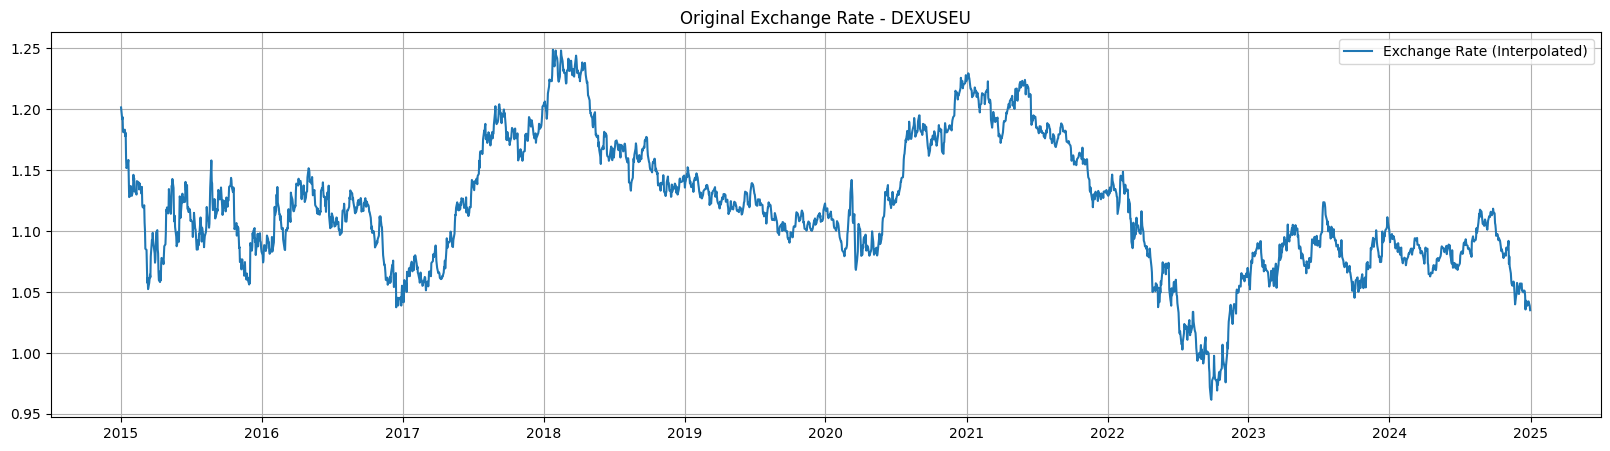

In [9]:
value_col_name = 'DEXUSEU'
file = 'DEXUSEU.csv'

df = clean_and_transform_data(file, 'observation_date', value_col_name)

# Visualization
fig, axes = plt.subplots(1, 1, figsize=(20, 5), sharex=True)

# Plot of the original, interpolated series
axes.plot(df.index, df['rate_interpolated'], label='Exchange Rate (Interpolated)')
axes.set_title(f'Original Exchange Rate - {value_col_name}')
axes.legend()
axes.grid(True)
# Split at desired point
train_df, test_df = split_train_test(df, split_date="2022-12-31")

# Perform first differencing
train_df = difference_series(train_df, col='log_rate')

In [10]:
# Split at desired point
train_df, test_df = split_train_test(df, split_date="2022-12-31")

# Perform first differencing
train_df = difference_series(train_df, col='log_rate')

# estimate trend (mu) 
mu_train, intercept_train, t_train, trend_line_train = estimate_trend(train_df)
train_df = compute_Wt(train_df, mu_train) # diff() - mu

train_df

Train samples: 2086 | Test samples: 522
Estimated trend (mu): -0.000004


,rate,rate_interpolated,log_rate,diff,Wt
date,,,,,
2015-01-06,1.1936,1.1936,0.176974,0.001509,0.001513
2015-01-07,1.1820,1.1820,0.167208,-0.009766,-0.009762
2015-01-08,1.1811,1.1811,0.166446,-0.000762,-0.000758
2015-01-09,1.1830,1.1830,0.168054,0.001607,0.001611
2015-01-12,1.1832,1.1832,0.168223,0.000169,0.000173
...,...,...,...,...,...
2022-12-23,1.0621,1.0621,0.060248,0.003112,0.003116
2022-12-27,1.0654,1.0654,0.063350,0.003102,0.003106
2022-12-28,1.0622,1.0622,0.060342,-0.003008,-0.003004


In [11]:
# Export test_df to CSV
test_df.to_csv('test_df_dexuseu.csv')

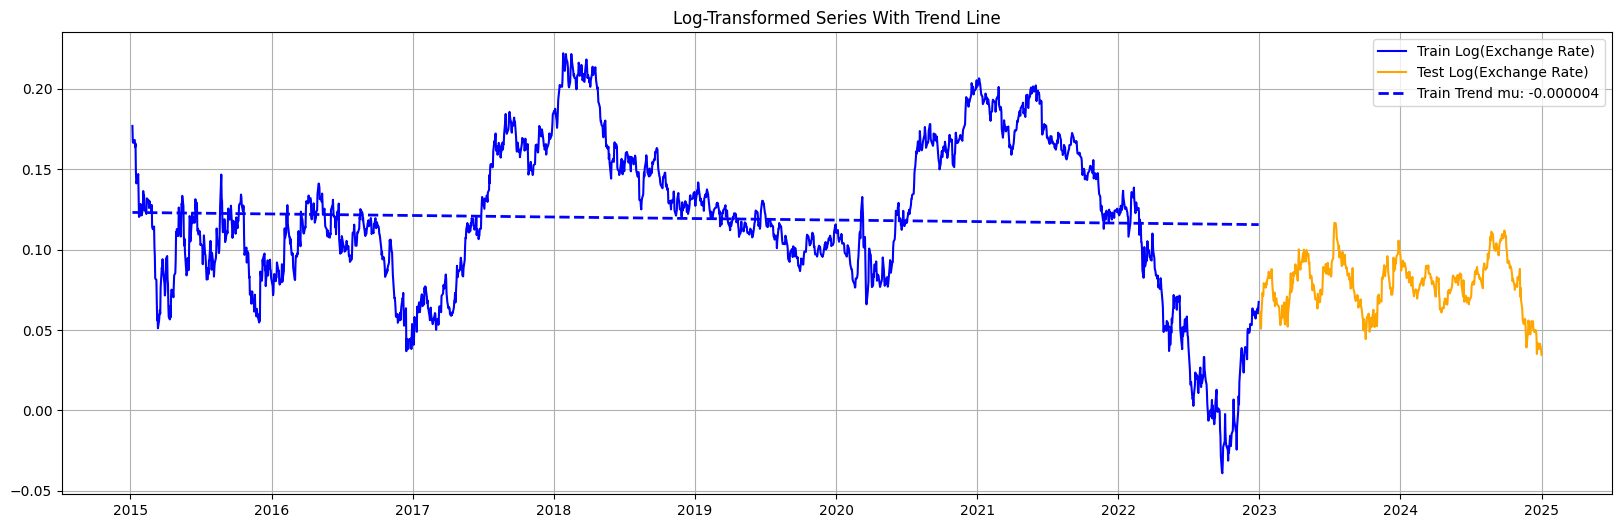

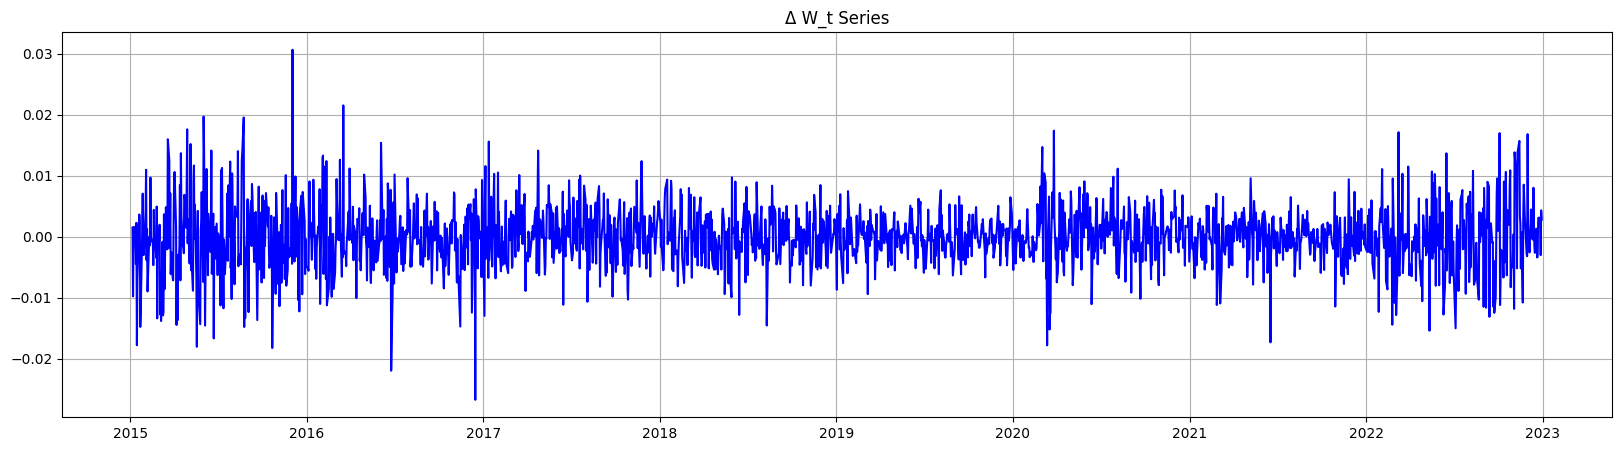

In [12]:
# Plot train and test of the log-transformed series, with trend lines
fig, ax = plt.subplots(1, 1, figsize=(20, 6), sharex=True)

# Plot train and test of the log-transformed series
ax.plot(train_df.index, train_df['log_rate'], label='Train Log(Exchange Rate)', color='blue')
ax.plot(test_df.index, test_df['log_rate'], label='Test Log(Exchange Rate)', color='orange')

# Plot trend lines (align lengths after differencing)
ax.plot(train_df.index, trend_line_train[1:], label=f'Train Trend mu: {mu_train:.6f}', color='blue', linestyle='--', linewidth=2)

ax.set_title('Log-Transformed Series With Trend Line')
ax.legend()
ax.grid(True)

#plot the W_t
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(train_df.index, train_df['Wt'], label='Train W_t', color='blue')
ax.set_title('Δ W_t Series')
ax.grid(True)       


In [13]:
# Testing Stationarity of W_t
test_stationarity(train_df['Wt'])


--- ADF Test ---
ADF Statistic: -14.4127
p-value: 0.0000
ADF: Reject null → likely stationary.


In [14]:
# testing stationarity of W_t without subtracting mu
test_stationarity(train_df['diff'])


--- ADF Test ---
ADF Statistic: -14.4127
p-value: 0.0000
ADF: Reject null → likely stationary.


In [15]:
"""
For the DEXUSEU exchange rate series, the log-transformed levels were tested for a deterministic trend by 
regressing the series on a linear time trend. The estimated drift parameter was found to be approximately zero (
μ=-0.000004), indicating no significant deterministic trend in the log-levels.

The first difference of the log series, interpreted as the innovation term 
Wt, was tested for stationarity using the Augmented Dickey-Fuller test. 
The test statistic was -14.41 with a p-value < 0.01, 
leading to rejection of the unit root null hypothesis. 
This supports the assumption that the increments of the exchange rate follow a stationary process, 
consistent with the Random Walk Hypothesis for exchange rate modelling
"""

'\nFor the DEXUSEU exchange rate series, the log-transformed levels were tested for a deterministic trend by \nregressing the series on a linear time trend. The estimated drift parameter was found to be approximately zero (\nμ=-0.000004), indicating no significant deterministic trend in the log-levels.\n\nThe first difference of the log series, interpreted as the innovation term \nWt, was tested for stationarity using the Augmented Dickey-Fuller test. \nThe test statistic was -14.41 with a p-value < 0.01, \nleading to rejection of the unit root null hypothesis. \nThis supports the assumption that the increments of the exchange rate follow a stationary process, \nconsistent with the Random Walk Hypothesis for exchange rate modelling\n'

In [16]:
# Export train_df to CSV for use in another notebook
train_df.to_csv('train_df_dexuseu.csv')

## --- Processing DEXSFUS.csv ---

In [17]:
def invert_column(df, col='DEXSFUS', new_col='DEXSFUS_inverted'):
    """
    Adds a new column to the DataFrame with the inverted values of the specified column (1/value).
    """
    df[new_col] = 1 / df[col]
    return df

In [18]:
value_col_name = 'DEXSFUS'
file = 'DEXSFUS.csv'

df = invert_column(df, col=value_col_name, new_col=f'{value_col_name}_inverted')
df = clean_and_transform_data(file, 'observation_date',value_col=f'{value_col_name}_inverted')

# Visualization
fig, ax = plt.subplots(1, 1, figsize=(20, 5), sharex=True)

# Plot of the original, interpolated series
ax.plot(df.index, df['rate_interpolated'], label='Exchange Rate (Interpolated)')
ax.set_title(f'Original Exchange Rate - {value_col_name}')
ax.legend()
ax.grid(True)

KeyError: 'DEXSFUS'

In [18]:
# Split at desired point
train_df, test_df = split_train_test(df, split_date="2022-12-31")

# Perform first differencing
train_df = difference_series(train_df, col='log_rate')

# estimate trend (mu) 
mu_train, intercept_train, t_train, trend_line_train = estimate_trend(train_df)
train_df = compute_Wt(train_df, mu_train) # diff() - mu

train_df.head()

Train samples: 2086 | Test samples: 522
Estimated trend (mu): 0.000123


,rate,rate_interpolated,log_rate,diff,Wt
date,,,,,
2015-01-06,11.7005,11.7005,2.459632,-0.001281,-0.001404
2015-01-07,11.7075,11.7075,2.460230,0.000598,0.000475
2015-01-08,11.5530,11.5530,2.446945,-0.013285,-0.013408
2015-01-09,11.4850,11.4850,2.441042,-0.005903,-0.006026
2015-01-12,11.5260,11.5260,2.444605,0.003564,0.003440


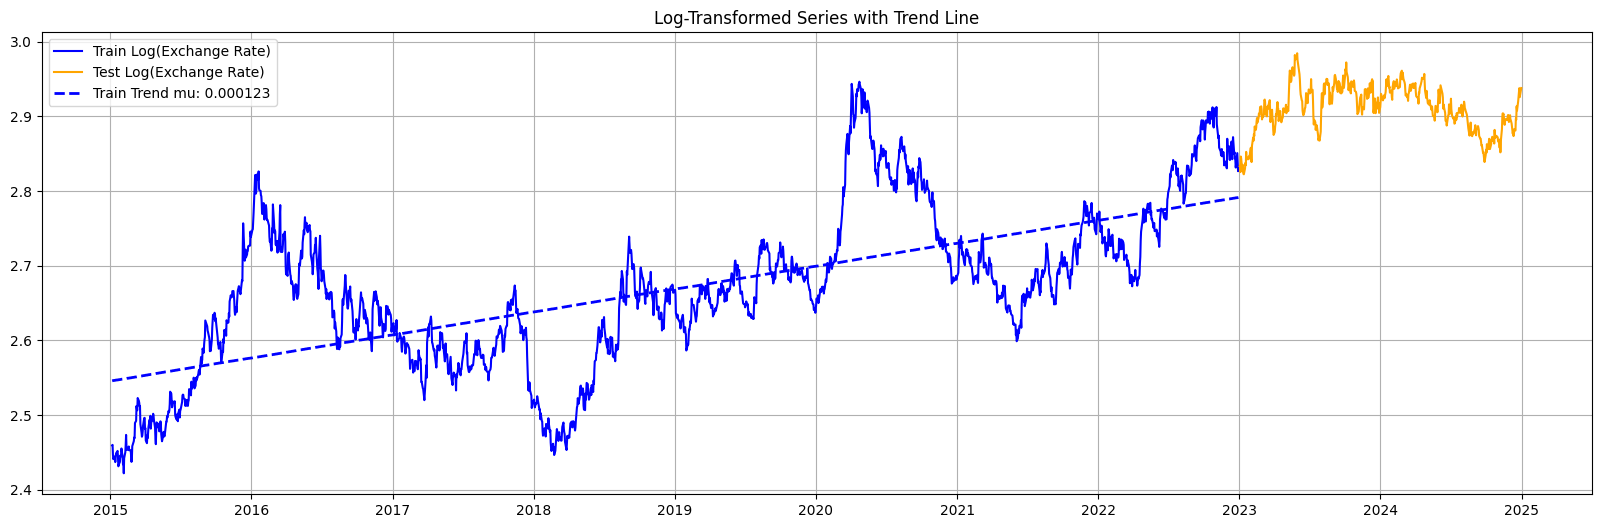

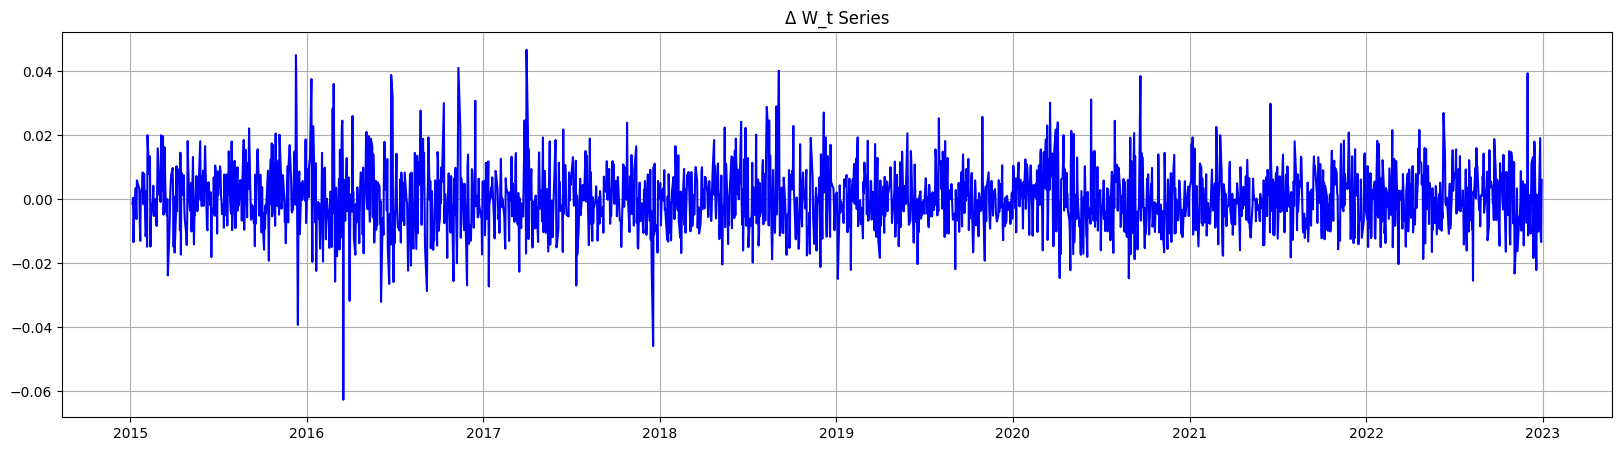

In [19]:
# Plot train and test of the log-transformed series, with trend lines
fig, ax = plt.subplots(1, 1, figsize=(20, 6), sharex=True)

# Plot train and test of the log-transformed series
ax.plot(train_df.index, train_df['log_rate'], label='Train Log(Exchange Rate)', color='blue')
ax.plot(test_df.index, test_df['log_rate'], label='Test Log(Exchange Rate)', color='orange')

# Plot trend lines (align lengths after differencing)
ax.plot(train_df.index, trend_line_train[1:], label=f'Train Trend mu: {mu_train:.6f}', color='blue', linestyle='--', linewidth=2)

ax.set_title('Log-Transformed Series with Trend Line')
ax.legend()
ax.grid(True)
plt.show()

#plot the W_t
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(train_df.index, train_df['Wt'], label='Train W_t', color='blue')
ax.set_title('Δ W_t Series')
ax.grid(True)  

In [20]:
# Testing Stationarity of W_t
test_stationarity(train_df['Wt'])


--- ADF Test ---
ADF Statistic: -43.6102
p-value: 0.0000
ADF: Reject null → likely stationary.


In [21]:
# Testing stationarity of W_t without subtracting mu
test_stationarity(train_df['diff']) 


--- ADF Test ---
ADF Statistic: -43.6102
p-value: 0.0000
ADF: Reject null → likely stationary.


In [22]:
# Export train_df to CSV for use in another notebook
train_df.to_csv('train_df_dexsfus.csv')

## --- Processing PENUSD.csv ---

Processing data from: PENUSD.csv
Found and filled 113 missing values.


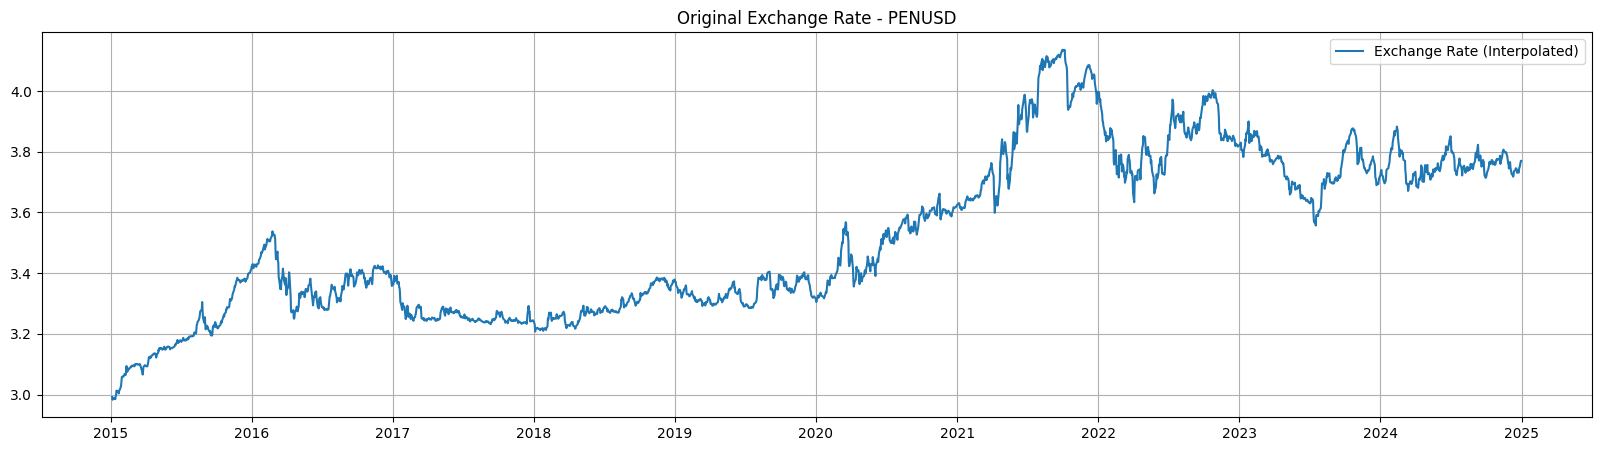

In [23]:
# Note: This file requires special handling for Spanish date abbreviations ('Ene')
# and the 'n.d.' null values.
month_abbreviation_to_number = {
    'Ene': '01', 'Feb': '02', 'Mar': '03', 'Abr': '04', 'May': '05', 'Jun': '06',
    'Jul': '07', 'Ago': '08', 'Set': '09', 'Oct': '10', 'Nov': '11', 'Dic': '12'
}

value_col_name = 'PENUSD'
file = 'PENUSD.csv'
    
df = clean_and_transform_data(
    file, 
    'observation_date', 
    value_col_name,
    date_format='%d%m%y', # Format for dates like '01Jan15'
    na_values=['n.d.'],
    month_map=month_abbreviation_to_number
)

# Visualization
Fig, ax = plt.subplots(1, 1, figsize=(20, 5), sharex=True)

# Plot of the original, interpolated series
ax.plot(df.index, df['rate_interpolated'], label='Exchange Rate (Interpolated)')
ax.set_title(f'Original Exchange Rate - {value_col_name}')
ax.legend()
ax.grid(True)




In [24]:
# Split at desired point
train_df, test_df = split_train_test(df, split_date="2022-12-31")

# Perform first differencing
train_df = difference_series(train_df, col='log_rate')

# estimate trend (mu) 
mu_train, intercept_train, t_train, trend_line_train  = estimate_trend(train_df)
train_df = compute_Wt(train_df, mu_train) # diff() - mu

train_df.head()

Train samples: 2085 | Test samples: 522
Estimated trend (mu): 0.000108


,rate,rate_interpolated,log_rate,diff,Wt
date,,,,,
2015-01-07,2.987,2.987,1.094270,0.001340,0.001232
2015-01-08,2.989,2.989,1.094939,0.000669,0.000562
2015-01-09,2.986,2.986,1.093935,-0.001004,-0.001112
2015-01-12,2.989,2.989,1.094939,0.001004,0.000896
2015-01-13,2.985,2.985,1.093600,-0.001339,-0.001447


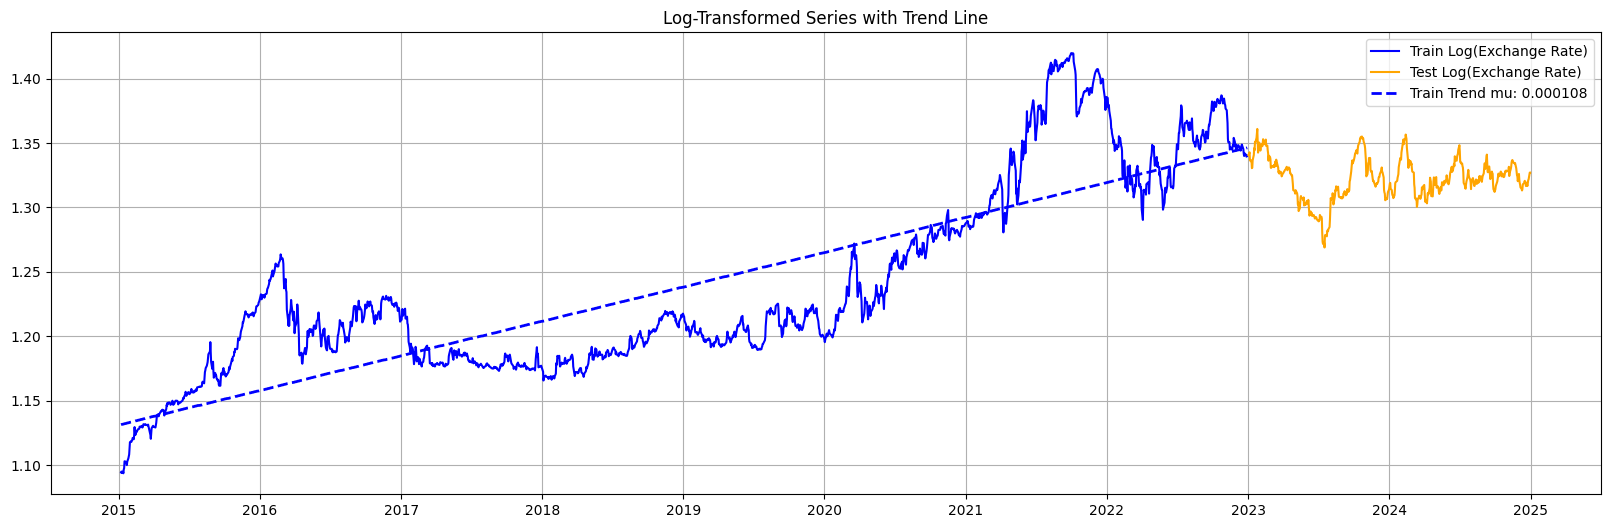

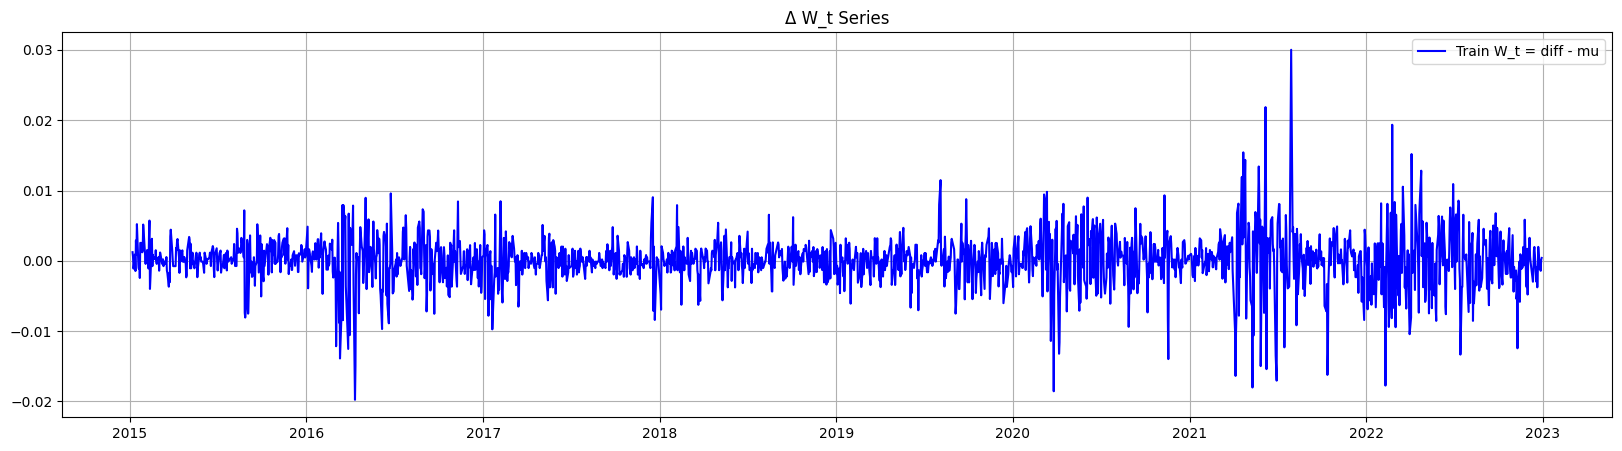

In [25]:
# Plot train and test of the log-transformed series, with trend lines
fig, ax = plt.subplots(1, 1, figsize=(20, 6), sharex=True)

# Plot train and test of the log-transformed series
ax.plot(train_df.index, train_df['log_rate'], label='Train Log(Exchange Rate)', color='blue')
ax.plot(test_df.index, test_df['log_rate'], label='Test Log(Exchange Rate)', color='orange')

# Plot trend lines (align lengths after differencing)
ax.plot(train_df.index, trend_line_train[1:], label=f'Train Trend mu: {mu_train:.6f}', color='blue', linestyle='--', linewidth=2)

ax.set_title('Log-Transformed Series with Trend Line')
ax.legend()
ax.grid(True)
plt.show()

#plot the W_t
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(train_df.index, train_df['Wt'], label='Train W_t = diff - mu', color='blue')
ax.legend()
ax.set_title('Δ W_t Series')
ax.grid(True)  

In [26]:
# Testing Stationarity of W_t
test_stationarity(train_df['Wt'])


--- ADF Test ---
ADF Statistic: -30.7776
p-value: 0.0000
ADF: Reject null → likely stationary.


In [27]:
#testing stationarity of W_t without subtracting mu
test_stationarity(train_df['diff'])


--- ADF Test ---
ADF Statistic: -30.7776
p-value: 0.0000
ADF: Reject null → likely stationary.


In [386]:
"""
the more negative the test sratistic, the stronger the evidence against the null hypothesis of a unit root (non-stationary).


"""

'\nthe more negative the test sratistic, the stronger the evidence against the null hypothesis of a unit root (non-stationary).\n\n\n'

In [387]:
# Export train_df to CSV for use in another notebook
train_df.to_csv('train_df_penusd.csv')